## A Snake's Adventure

#### Will you find the name of the snake?

- Detect a template in an image.
- Since all images have 4 sections and there is no noise, we can simply use $\arg \max_i \sum \left( \text{section}_i == \text{template} \right)$.
- After getting N/S/W/E locations of the template, reconstruct a path, and plot it.

**Solution: `CASSSSSSSSCABEL`**

In [1]:
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import *
from collections import namedtuple

import cv2
import torch as T
import torchvision 

from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [2]:
ROOT = Path('../data-puzzles-assets/computervision/snakes')

Sections = namedtuple('Sections', ['N', 'S', 'W', 'E'])
i2n = dict(zip(range(4), "NSWE"))


def get_dataset(root: Path) -> [np.ndarray]:
    return [cv2.imread(str(f)) for f in sorted(root.iterdir())]


def make_grid(dataset: [np.ndarray], rows: int) -> np.ndarray:
    ts = [T.tensor(x.transpose((2, 1, 0))) for x in dataset]
    grid = torchvision.utils.make_grid(ts, nrow=rows)
    return np.transpose(grid, (2, 1, 0))


def get_sections(img: np.ndarray) -> Sections:
    assert img.shape == (N, N, 3)
    sz = N // 2
    
    n = img[:sz, :sz]
    s = img[:sz, sz:]
    w = img[sz:, :sz]
    e = img[sz:, sz:]
    
    sections = [n, s, w, e]
    assert all(x.shape == (sz, sz, 3) for x in sections)
    
    return Sections(*sections)


def recognize_position(img: np.ndarray, template: np.ndarray) -> str:
    """
    N | S
    W | E
    """
    f = lambda x : normalize(rgb2gray(x))
    ms = [np.sum(f(template) == f(x)) for x in get_sections(img)]
    return i2n[np.argmax(ms)]


def rgb2gray(rgb: np.ndarray) -> np.ndarray:
    return np.round(np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])).astype(np.uint8)


def normalize(img: np.ndarray) -> np.ndarray:
    return (img / 255).astype(np.float32)


def plot_grid(grid: np.ndarray, figsize=(32, 20)) -> None:
    plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.axis('off')
    plt.grid(False)

    
def plot_sections(xs: [np.ndarray], figsize=(10,10)) -> None:
    plt.figure(figsize=figsize)
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(xs[i])
        plt.axis('off')
        plt.grid(False)
        plt.title(i2n[i], fontsize=14)
        
        
def mask_section(img: np.ndarray, section: str) -> np.ndarray:
    sz = N // 2
    mask = np.zeros((N, N)).astype(img.dtype)
    
    if section == 'N':
        mask[:sz, :sz] = 1
    if section == 'S':
        mask[:sz, sz:] = 1
    if section == 'W':
        mask[sz:, :sz] = 1
    if section == 'E':
        mask[sz:, sz:] = 1
        
    out = img.copy()
    for i in range(3):
        out[:, :, i] *= mask
        
    return out

In [3]:
dataset = get_dataset(ROOT)
orig_grid = make_grid(dataset, rows=9)
N = dataset[0].shape[0]

snake = get_sections(dataset[0]).E
recon = [recognize_position(img, snake) for img in dataset]

f = lambda x: normalize(rgb2gray(x))
ts = [mask_section(dataset[i], recon[i]) for i in range(len(dataset))]
ts = [T.tensor(t.transpose((2, 1, 0))) for t in ts]
mask_grid = torchvision.utils.make_grid(ts, nrow=9)
mask_grid = np.transpose(mask_grid, (2, 1, 0))

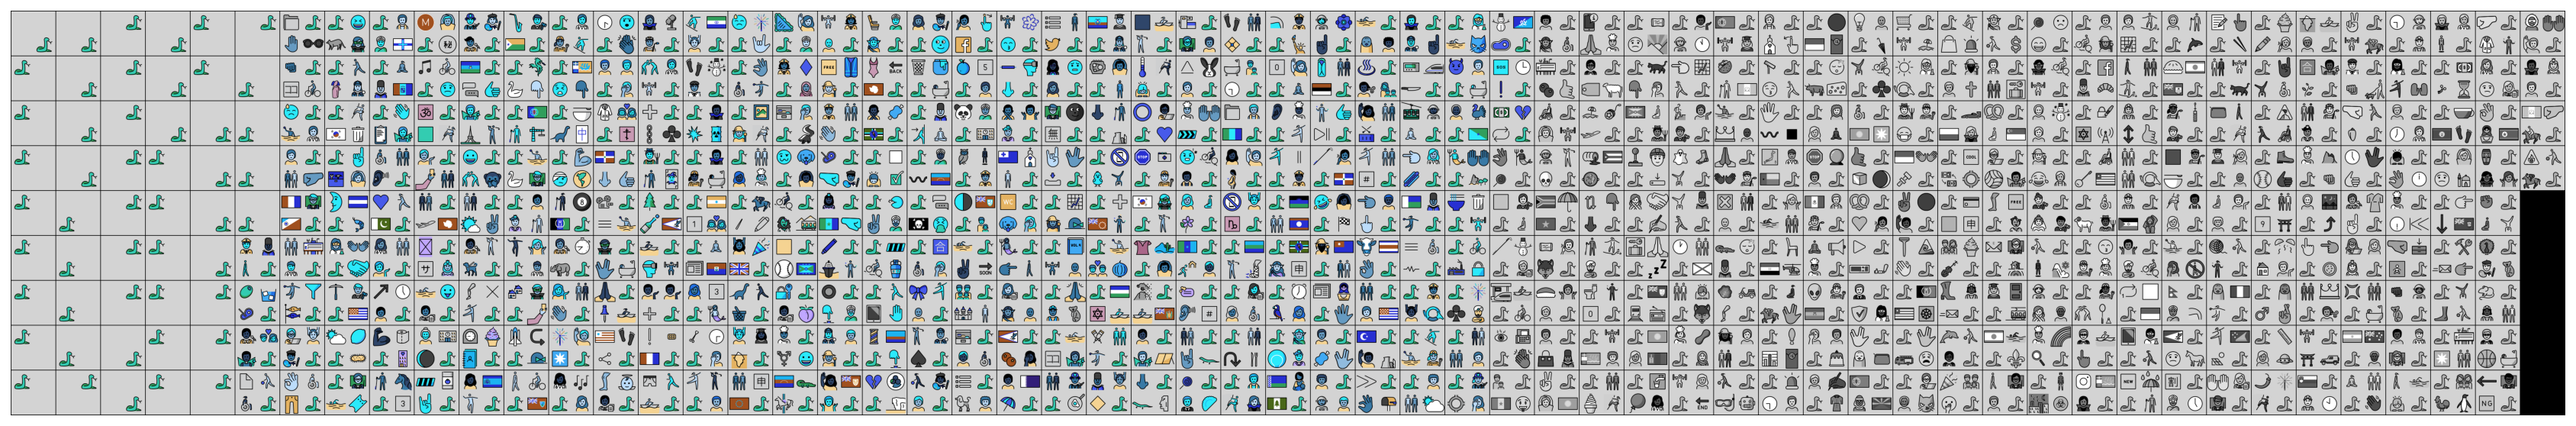

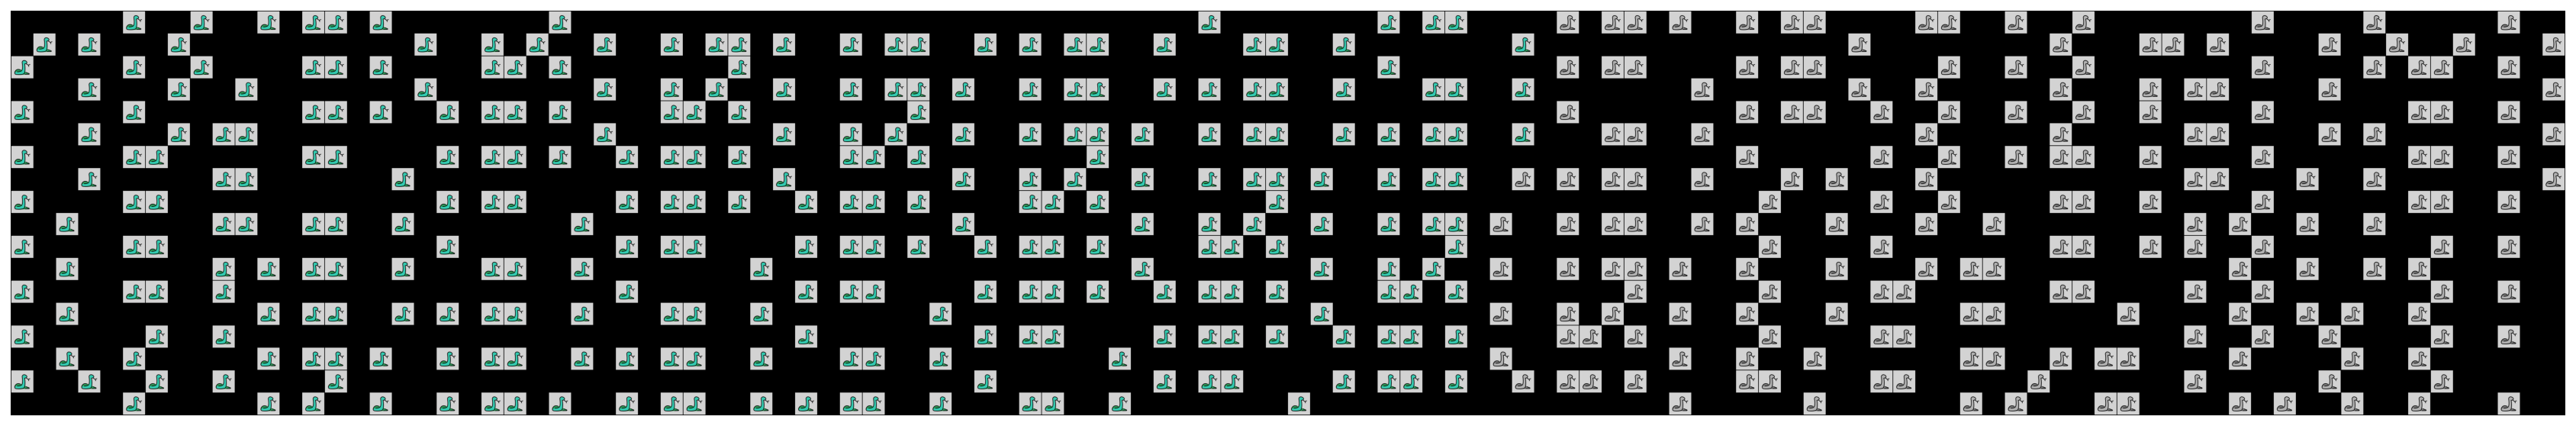

In [4]:
plot_grid(orig_grid, figsize=(30,12))
plot_grid(mask_grid, figsize=(30,12))

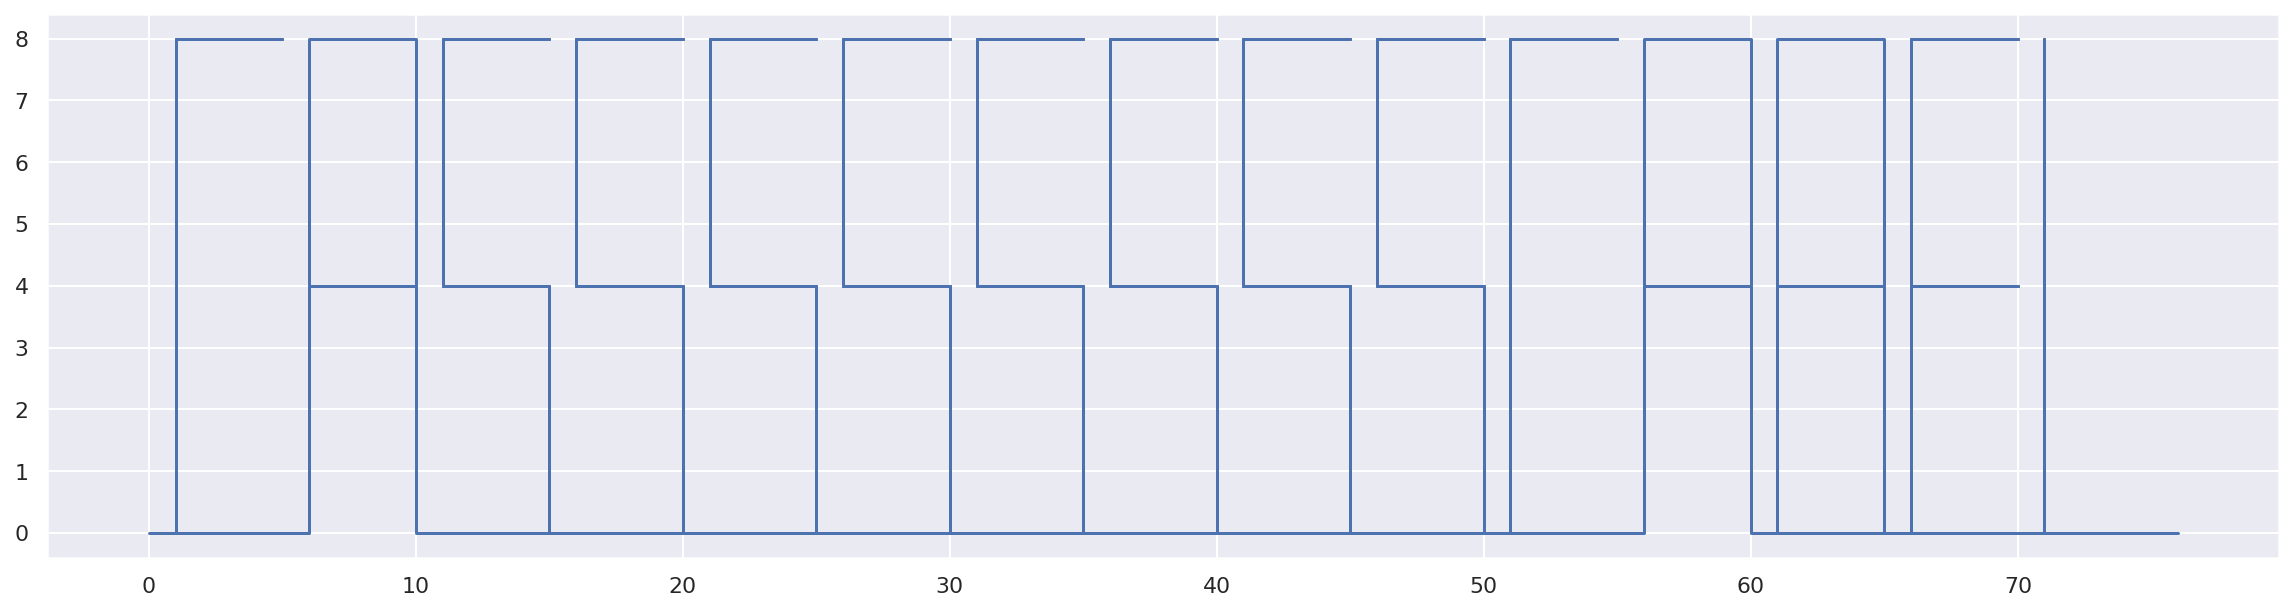

In [5]:
delta = {
    'N': ( 0,  1),
    'S': ( 0, -1),
    'W': (-1,  0),
    'E': ( 1,  0)
}

xs, ys = [0], [0]
for r in recon:
    dx, dy = delta[r]
    xs.append(xs[-1] + dx)
    ys.append(ys[-1] + dy)
    

plt.figure(figsize=(20, 5))
plt.plot(xs, ys)